In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d as intp
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc

utils.configure_plot_params()

/Users/runburg/github/agn_lf


In [2]:
# catalog = table.Table.read('./data/master_cat_irac3_mips24')
catalog = table.Table.read('./data/help_full_catalog_with_fluxes_and_redshifts.fits')

bands = np.array([3.6, 4.5, 5.8, 8, 24])
flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
photoz = 'redshift'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]
ct_lacy = ct_lacy[(np.nan_to_num(ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy['zspec'], nan=-99) > 0)][flux36, flux45, flux58, flux80, flux240]

print(np.sum(selected_agn))

5918


In [3]:
utils.configure_plot_params()
import seaborn as sns
sns.set_theme(style="whitegrid")

In [4]:
means = np.array(list(ct_lacy.groups.aggregate(np.mean)[0]))
stds = np.array(list(ct_lacy.groups.aggregate(np.std)[0]))


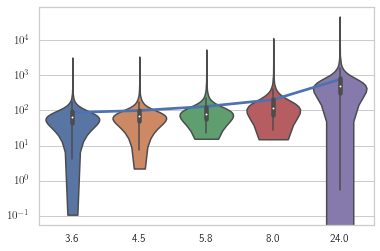

In [5]:
# ct_lacy["Band"] = [flux36, flux45, flux58, flux80, flux240]
ct = ct_lacy.to_pandas()
ct.columns = bands
ax = sns.pointplot(data=ct, ci=None)
ax = sns.violinplot(data=ct, scale='count', gridsize=500, cut=.2)

ax.set_yscale('log')
# plt.savefig('./output/paper_plots/violin_sed_ir.png')

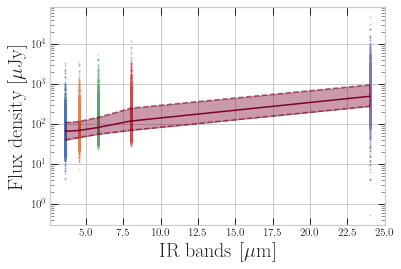

In [6]:
utils.configure_plot_params()
fig, ax = plt.subplots()
# means = np.mean(ct_lacy, axis=1)
bands = np.array([3.6, 4.5, 5.8, 8, 24])
color = 'xkcd:bordeaux'
# ax.plot(bands, means, color=color)
# ax.plot(bands, means - stds, color=color, alpha=0.6)
# ax.plot(bands, means + stds, color=color, alpha=0.6)
# ax.fill_between(bands, means + stds, means - stds, color=color, alpha=0.4)
mean, up, down = [], [], []
for num, col in zip(bands, ct_lacy.colnames):
    ax.scatter([num]*len(ct_lacy), ct_lacy[col], s=1, alpha=0.3)
    sortcol = np.sort(ct_lacy[col])
    num = len(sortcol)
    mean.append(sortcol[num//2])
    up.append(sortcol[int(num * 0.8)])
    down.append(sortcol[int(num * 0.2)])
    
ax.plot(bands, mean, color=color)
ax.plot(bands, up, '--', color=color, alpha=0.6)
ax.plot(bands, down, '--', color=color, alpha=0.6)
ax.fill_between(bands, up, down, color=color, alpha=0.4)
ax.set_xlabel(r'IR bands [$\mu$m]')
ax.set_ylabel(r'Flux density [$\mu$Jy]')
ax.set_yscale('log')
fig.savefig('./output/paper_plots/sed_ir.pdf')

In [7]:
means, stds, means - stds

(array([ 87.68940033,  99.68962283, 130.73125549, 204.00231666,
        776.33581162]),
 array([ 117.13363063,  145.99117911,  214.67244533,  362.60067951,
        1343.35801257]),
 array([ -29.4442303 ,  -46.30155628,  -83.94118984, -158.59836285,
        -567.02220096]))

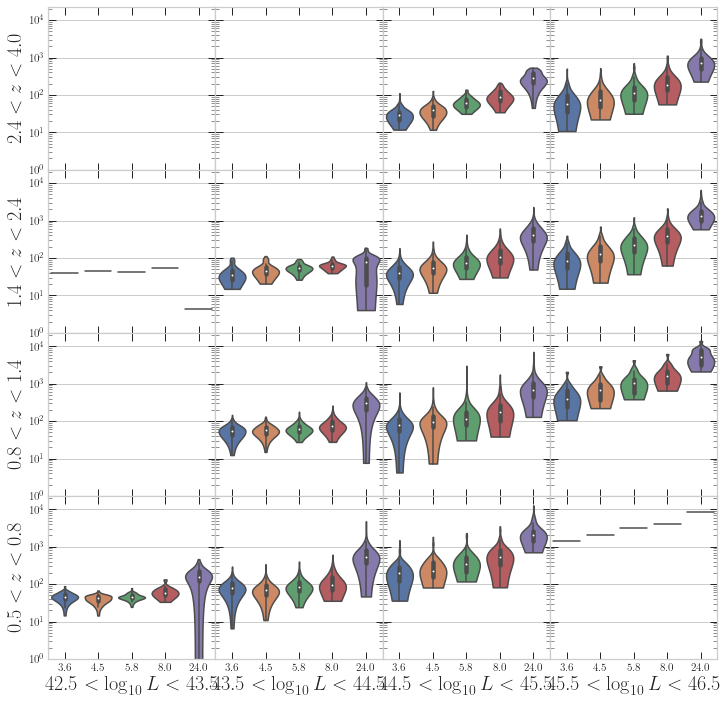

In [8]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42 #erg/s
l_sample_max = 3e46 #erg/s 

cosmo = af.setup_cosmology()
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15

num_bins_z = 5
num_bins_l = 5
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

cato = catalog[never_nan][selected_agn]
cato = cato[(np.nan_to_num(cato[photoz], nan=-99) > 0 ) | (np.nan_to_num(cato['zspec'], nan=-99) > 0)]

fig, axs = plt.subplots(nrows=num_bins_z-1, ncols=num_bins_l-1, figsize=(12, 12), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
spectral_index = np.log10(cato[flux240].data/cato[flux58].data) / np.log10(24/5.8)

z = np.array([row['zspec'] if row['zspec'] > 0 else row[photoz] for row in cato])  
l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * cato[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index)

for i in range(num_bins_z - 1):
    for j in range(num_bins_l - 1):
        inbin = (l > l_bins[j]) & (l < l_bins[j+1]) & (z > z_bins[i]) & (z < z_bins[i+1])
        ax = sns.violinplot(data=ct[inbin], scale='count', gridsize=500, cut=0, bw=0.5, ax=axs[len(z_bins)-2-i, j])

for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    
for i, ax in enumerate(reversed(axs[:, 0])):
    lab = rf"${z_bins[i]:.1f} < z < {z_bins[i+1]:.1f}$"
    ax.set_ylabel(lab)

for i, ax in enumerate(axs[-1]):
    lab = rf"${np.log10(l_bins[i]):.1f} < \log_{{10}}L < {np.log10(l_bins[i+1]):.1f}$"
    ax.set_xlabel(lab)
    
fig.savefig('./output/paper_plots/ir_seds.pdf')

In [9]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
bands = ['Soft', 'Hard']
soft = 'SB_FLUX'
hard = 'HB_FLUX'
full = 'FB_FLUX'
never_nan = (np.nan_to_num(xservs_catalog[soft], nan=-99) > 0) & (np.nan_to_num(xservs_catalog[hard], nan=-99) > 0) & (np.nan_to_num(xservs_catalog[full], nan=-99) > 0) & ((np.nan_to_num(xservs_catalog['ZPHOT'], nan=-99) > 0) | (np.nan_to_num(xservs_catalog['ZSPEC'], nan=-99) > 0))
xscat = xservs_catalog[never_nan][soft, hard]

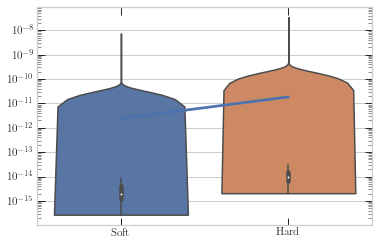

In [10]:
ct = xscat.to_pandas()
ct.columns = bands
ax = sns.pointplot(data=ct, ci=None)
ax = sns.violinplot(data=ct, scale='count', gridsize=1000, cut=0)

ax.set_yscale('log')
plt.savefig('./output/violin_sed_xray.png')

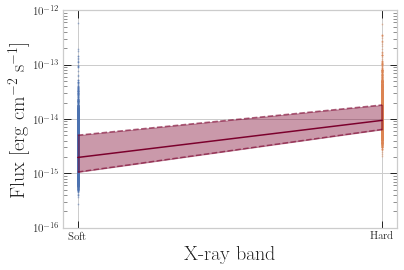

In [11]:
fig, ax = plt.subplots()
mean, up, down = [], [], []
for num, col in zip([0, 1], xscat.colnames):
    ax.scatter([num]*len(xscat), xscat[col], s=1, alpha=0.3)
    sortcol = np.sort(xscat[col])
    num = len(sortcol)
    mean.append(sortcol[num//2])
    up.append(sortcol[int(num * 0.8)])
    down.append(sortcol[int(num * 0.2)])

color = 'xkcd:bordeaux'
ax.plot([0, 1], mean, color=color)
ax.plot([0, 1], up, '--', color=color, alpha=0.6)
ax.plot([0, 1], down, '--', color=color, alpha=0.6)
ax.fill_between(bands, up, down, color=color, alpha=0.4)
ax.set_yscale('log')
ax.set_ylim(bottom=1e-16, top=1e-12)
ax.set_xlabel('X-ray band')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$]')
fig.savefig('./output/paper_plots/sed_xray.pdf')

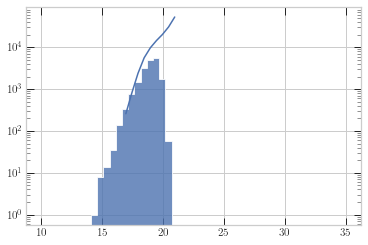

In [15]:
tab = table.Table(catalog)

# shift i3 to i2 mags
mags = tab['m_ap_irac_i3'] #- 2.5 * np.log10(tab['f_ap_irac_i3']/tab['f_ap_irac_i2'])

fig, ax = plt.subplots()
bins = np.linspace(10, 35, num=50)
histo, bins, _ = ax.hist(mags.data, bins=bins, color='b', histtype='stepfilled', alpha=0.8)
# ashby = np.loadtxt('./data/ashby_uds_corrected_counts.csv', delimiter=',').T
ashby = np.loadtxt('./data/barmby_ir_counts_58.csv', delimiter=',').T
match_lower = 0.8 
mag_shift = 1.3
ax.plot(ashby[0] - mag_shift, ashby[1] * match_lower)
ax.set_yscale('log')
# ax.set_xscale('log')


<ipython-input-17-ca1b555167f5>:9: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_centers, histo/correction_coeffs, color='xkcd:wine')


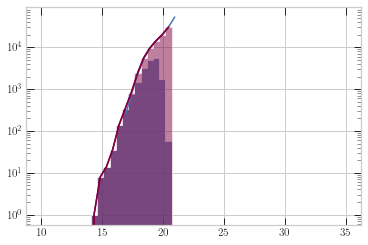

In [17]:
ashby_fn = intp(ashby[0] - mag_shift, ashby[1] * match_lower, kind='nearest', fill_value=ashby[1, -1]*match_lower, bounds_error=False)
bin_centers = (bins[1:] + bins[:-1]) / 2
# bin_centers = bins[:-1]
uncorrected_mags = (bin_centers < ashby[0][0] - mag_shift) #| (bin_centers > ashby[0][-1] - mag_shift)
correction_coeffs = histo / ashby_fn(bin_centers) 
correction_coeffs[uncorrected_mags] = 1
# print(correction_coeffs)
crctn_fn = intp(bin_centers, correction_coeffs, kind='nearest', bounds_error=False, fill_value='extrapolate')
ax.plot(bin_centers, histo/correction_coeffs, color='xkcd:wine')
ax.hist(mags.data, bins=bins, color='xkcd:wine', alpha=0.5, weights=1/crctn_fn(mags.data), histtype='stepfilled')
fig
# correction_coeffs

array([1.        , 1.        , 0.63293716, 0.51630106, 0.08412315,
       0.        , 0.        ])

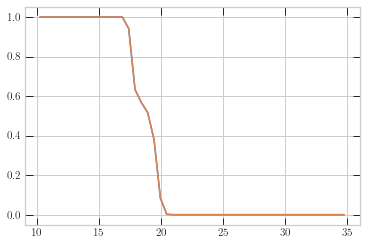

In [18]:
plt.plot(bin_centers, correction_coeffs)
plt.plot(bin_centers, crctn_fn(bin_centers))
# plt.plot(bin_centers, ashby_fn(bin_centers))
crctn_fn(range(16, 23))

In [19]:
bin_fluxes = 3631 * 10**(bin_centers / -2.5) * 1e6

<ipython-input-24-ec87f70bcc36>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bin_fluxes, histo/correction_coeffs, color="xkcd:blue violet", label='Correction as function of flux')


  m_ap_irac_i3   f_ap_irac_i3
      mag            uJy     
---------------- ------------
18.8171445573484       107.93
17.1684334176213       492.75
18.8928576848472       100.66
18.3465948319911       166.48
 18.952153826133        95.31


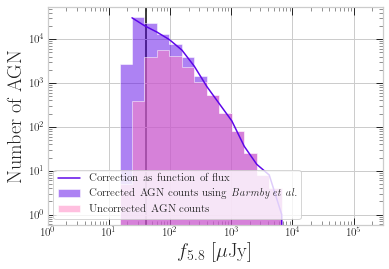

In [24]:
fig, ax = plt.subplots()
corrected_fluxes = tab['f_ap_irac_i3'].data #/ crctn_fn(tab['m_ap_irac_i3'].filled().data)
# bins = np.logspace(-4, 4, num=200)
ax.hist(corrected_fluxes, color="xkcd:blue violet", alpha=0.5, bins=np.flip(bin_fluxes), weights=1/crctn_fn(mags.data), histtype='stepfilled', label=r'Corrected AGN counts using \textit{Barmby et al.}')
ax.plot(bin_fluxes, histo/correction_coeffs, color="xkcd:blue violet", label='Correction as function of flux')
ax.hist(tab['f_ap_irac_i3'].data, color='xkcd:pink', alpha=0.5, bins=np.flip(bin_fluxes), histtype='stepfilled', label='Uncorrected AGN counts')
ax.set_xscale('log')
ax.set_xlabel(r'$f_{5.8}$ [$\mathrm{\mu Jy}$]')
# ax.set_xlabel(r'5.8 $\mathrm{\mu m}$ flux [$\mathrm{\mu Jy}$]')
ax.set_xlim(left=1e0, right=3e5)
ax.axvline(40, color='xkcd:black', zorder=-100)
ax.set_yscale('log')
ax.set_ylabel('Number of AGN')
# ax.set_ylabel('AGN')
ax.legend(loc='lower left')
fig.savefig('./output/paper_plots/corrected_fluxes.pdf', bbox_inches='tight')
print(tab[0:5]['m_ap_irac_i3', 'f_ap_irac_i3'])

In [ ]:
mags = catalog['m_ap_irac_i3'][np.nan_to_num(catalog['zspec'], nan=-99) > 0]
print(len(mags))
fig, ax = plt.subplots()
bins = np.linspace(10, 35, num=50)
histo, bins, _ = ax.hist(mags.filled().data, bins=bins, color='b', histtype='stepfilled', alpha=0.8)
# ashby = np.loadtxt('./data/ashby_uds_corrected_counts.csv', delimiter=',').T
ashby = np.loadtxt('./data/barmby_ir_counts_58.csv', delimiter=',').T
match_lower = 0.8 
mag_shift = 1.3
ax.plot(ashby[0] - mag_shift, ashby[1] * match_lower)
ax.set_yscale('log')

ashby_fn = intp(ashby[0] - mag_shift, ashby[1] * match_lower, kind='nearest', fill_value='extrapolate', bounds_error=False)
# uncorrected_mags = np.argmax(histo < ashby[0][0] - mag_shift).astype(int) #| (bin_centers > ashby[0][-1] - mag_shift)
uncorrected_mags = (bin_centers < ashby[0][0] - mag_shift) #| (bin_centers > ashby[0][-1] - mag_shift)
correction_coeffs = histo / ashby_fn(bin_centers) 
correction_coeffs[uncorrected_mags] = 1
np.savez('./data/incompleteness_corrections_mag_specz_only.npz', corrs=correction_coeffs, mags=bin_centers, fluxes=bin_fluxes)

In [ ]:
catalog = table.Table.read('./data/xmatch_catalog_1_arcsec.fits')
ra_up = 36.5
ra_down = 34.25
dec_up = -4.0
dec_down = -5.5
catalog = catalog[(ra_down < catalog['ra_1']) & (catalog['ra_1'] < ra_up)& (dec_down < catalog['dec_1']) & (catalog['dec_1'] < dec_up)]
mags = catalog['m_ap_irac_i3']
fig, ax = plt.subplots()
bins = np.linspace(10, 35, num=50)
histo, bins, _ = ax.hist(mags.filled().data, bins=bins, color='b', histtype='stepfilled', alpha=0.8)
# ashby = np.loadtxt('./data/ashby_uds_corrected_counts.csv', delimiter=',').T
ashby = np.loadtxt('./data/barmby_ir_counts_58.csv', delimiter=',').T
match_lower = 0.1
mag_shift = 1.25
ax.plot(ashby[0] - mag_shift, ashby[1] * match_lower)
ax.set_yscale('log')

ashby_fn = intp(ashby[0] - mag_shift, ashby[1] * match_lower, kind='nearest', fill_value='extrapolate', bounds_error=False)
# uncorrected_mags = np.argmax(histo < ashby[0][0] - mag_shift).astype(int) #| (bin_centers > ashby[0][-1] - mag_shift)
uncorrected_mags = (bin_centers < ashby[0][0] - mag_shift) | (bin_centers > ashby[0][-1] - mag_shift)
correction_coeffs = histo / ashby_fn(bin_centers) 
correction_coeffs[uncorrected_mags] = 1
print(correction_coeffs)
np.savez('./data/incompleteness_corrections_mag_crossmatch.npz', corrs=correction_coeffs, mags=bin_centers, fluxes=bin_fluxes)

In [ ]:
# plt.scatter(tab['f_ap_irac_i3'].filled().data, 1/crctn_fn(mags.filled().data), alpha=0.05)
# plt.xscale('log')
# plt.yscale('log')


In [ ]:
fluxes = 10**(-bin_centers/2.5)
np.savez('./data/incompleteness_corrections_mag.npz', corrs=correction_coeffs, mags=bin_centers, fluxes=bin_fluxes)

In [ ]:
plt.hist(- 2.5 * np.log10(tab['f_ap_irac_i3']/tab['f_ap_irac_i2']), bins=np.linspace(-3,2, num=100));
plt.yscale('log')

In [ ]:
np.mean(- 2.5 * np.log10(tab['f_ap_irac_i3']/tab['f_ap_irac_i2']))

In [ ]:
ircat = table.Table.read('./data/help_full_catalog_with_fluxes_and_redshifts.fits')
xcat = table.Table.read('./data/tableA.v01.fits')
# combo = table.Table.read('./data/CrossMatch-5arc')
combo = table.Table.read('./data/xmatch_catalog_1_arcsec.fits')

print(np.amin(ircat[flux58]))
# combo = combo[~np.isnan(combo['f_ap_irac_i3']) & ~np.isnan(combo['f_ap_irac_i4'])]
# combo.colnames

In [ ]:
ra_up = 36.5
ra_down = 34.25
dec_up = -4.0
dec_down = -5.5
print("crossmatch", np.sum((ra_down < combo['RA_2']) & (combo['RA_2'] < ra_up)& (dec_down < combo['DEC_2']) & (combo['DEC_2'] < dec_up)))
print("xray", np.sum((ra_down < xcat['RA']) & (xcat['RA'] < ra_up)& (dec_down < xcat['DEC']) & (xcat['DEC'] < dec_up)))
print("ir",  np.sum((ra_down < ircat['ra']) & (ircat['ra'] < ra_up)& (dec_down < ircat['dec']) & (ircat['dec'] < dec_up)))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ircat = ircat[~np.isnan(ircat[flux58])]
ax.scatter(ircat['ra'], ircat['dec'], color='xkcd:fire engine red', s=2, alpha=0.3, label="IR HELP")
ax.scatter(xcat['RA'], xcat['DEC'], color='xkcd:blueberry', s=2, alpha=0.5, label='XRAY XSERVS')
# ax.scatter(combo['RA_2'], combo['DEC_2'], color='xkcd:seaweed', s=2, alpha=0.5, label='CROSSMATCH')

ax.set_xlim(left=37.5, right=33)
ax.plot([ra_down, ra_down, ra_up, ra_up, ra_down], [dec_down, dec_up, dec_up, dec_down, dec_down], color='xkcd:midnight')
# ax.axhline(dec_down, 0, 1)
# ax.axhline(dec_up)
# ax.axvline(ra_down)
# ax.axvline(ra_up)
ax.legend(markerscale=5)
fig.savefig('./output/paper_plots/crossmatch_sources.pdf')


print(np.amin(ircat[flux58]))

In [ ]:
never_nan = (np.nan_to_num(combo[flux58], nan=-99) > 0) & (np.nan_to_num(combo[flux80], nan=-99) > 0) #& (np.nan_to_num(['zspec'], nan=-99) > 0)
selected_agn = sc.select_ir(combo[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')


In [ ]:
np.sum(selected_agn)

In [ ]:
combo

In [ ]:
from area import area
region = {'type':'Polygon', 'coordinates':[[[ra_up, dec_up], [ra_up, dec_down], [ra_down, dec_down], [ra_down, dec_up]]]}
area(region)